# Train and test DNN models for parking space prediction

In [1]:
import pandas as pd
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from scipy.stats import pearsonr


import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
target_time_period= 'july'
#target_time_period= 'sept_oct'

In [3]:
#To do: 
#0. training_rate =.7
#1.probar weather + flow
#2. concatenar julio + sept-oct

## General functions

In [4]:
def read_clean_subflows_fn(critera, time_period):
    subflows= {}
    for c in critera:
        df = pd.read_csv(os.path.join('data', 'INE_subflows','flow_criterion_{}_clean_{}.csv'.format(c, time_period)),
                       parse_dates=[0], index_col=0)
        subflows[c] = df
    return subflows

## Read zones 1 parking data (target variable)

In [5]:
zone1_j_df = pd.read_csv(os.path.join('data', 'parkings_JULIO', 'zone1.csv'), sep=';', parse_dates=['recvTime'], index_col='recvTime')
zone1_j_df.shape

(446, 1)

In [6]:
zone1_so_df = pd.read_csv(os.path.join('data', 'parkings_SEPT_OCT', 'zone1.csv'), sep=';', parse_dates=['recvTime'], index_col='recvTime')
zone1_so_df.shape

(480, 1)

In [7]:
zone1_df= pd.concat([zone1_j_df,zone1_so_df], axis=0)

In [8]:
zone1_df.shape

(926, 1)

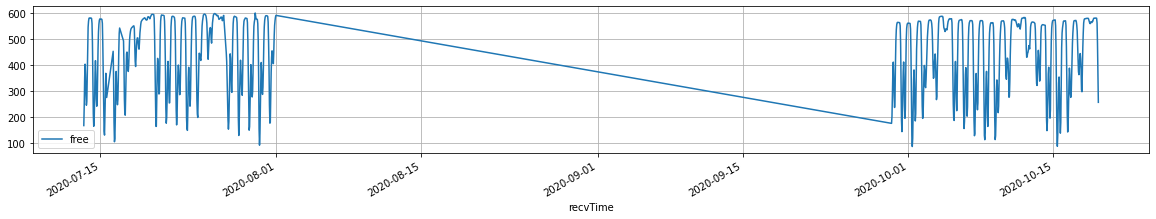

In [8]:
zone1_df.plot(figsize=(20,3),grid=True);

In [9]:
target_days = zone1_df.index
zone1_df.shape

(926, 1)

## Read subflows

In [10]:
target_criteria = range(6,11)

In [11]:
mob_flows_jul = read_clean_subflows_fn(target_criteria, 'july')
mob_flows_sept = read_clean_subflows_fn(target_criteria, 'sept_oct')

In [12]:
mob_flows= {}
for c in target_criteria:
    mob_flows[c] = pd.concat([mob_flows_jul[c], mob_flows_sept[c]], axis=0)

## Read meteorological data

In [13]:
target_days 

DatetimeIndex(['2020-07-13 10:00:00', '2020-07-13 11:00:00',
               '2020-07-13 12:00:00', '2020-07-13 13:00:00',
               '2020-07-13 14:00:00', '2020-07-13 15:00:00',
               '2020-07-13 16:00:00', '2020-07-13 17:00:00',
               '2020-07-13 18:00:00', '2020-07-13 19:00:00',
               ...
               '2020-10-18 23:00:00', '2020-10-19 00:00:00',
               '2020-10-19 01:00:00', '2020-10-19 02:00:00',
               '2020-10-19 03:00:00', '2020-10-19 04:00:00',
               '2020-10-19 05:00:00', '2020-10-19 06:00:00',
               '2020-10-19 07:00:00', '2020-10-19 08:00:00'],
              dtype='datetime64[ns]', name='recvTime', length=926, freq=None)

In [38]:
from datetime import datetime as dt
meteor_j = pd.read_csv(os.path.join('data', 'parkings_JULIO', 'meteor.txt'), sep=';', parse_dates={'date': ['fecha', 'hora']}, index_col='date')
#dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S')
#parse1 = lambda x: dt.strptime(x, '%%d/%m/%y %H:%M:%s')
#meteor_so = pd.read_csv(os.path.join('data', 'parkings_SEPT_OCT', 'meteor.txt'), sep=';', parse_dates={'date': ['fecha', 'hora']}, index_col='date')
#meteor_so = pd.read_csv(os.path.join('data', 'parkings_SEPT_OCT', 'meteor.txt')
#                        , sep=';', parse_dates = [['fecha', 'hora']],index_col = 0,
#                        date_parser=parse1)
meteor_so = pd.read_csv(os.path.join('data', 'parkings_SEPT_OCT', 'meteor.txt')
                        , sep=';')
#dt.strptime("2020-09-28 23:00:00","%Y-%m-%d %H:%M:%S")
meteor_so["date"] = meteor_so["fecha"] + meteor_so["hora"]
dtm = lambda x: dt.strptime(str(x), "%d/%m/%y%H:%M:%S")
meteor_so["date"] = meteor_so["date"].apply(dtm)
meteor_so = meteor_so.set_index('date')
meteor_so = meteor_so.drop(['fecha','hora'], axis=1)
meteor_so
meteor = pd.concat([meteor_j, meteor_so], axis=0)
meteor.shape

(937, 14)

In [39]:
meteor= meteor.loc[meteor.index.intersection(target_days)] 
print(meteor.shape)
meteor

(926, 14)


,tmed,tmax,tmin,hrmed,hrmax,hrmin,radmed,radmax,vvmed,vvmax,dvmed,prec,dewpt,dpv
2020-07-13 10:00:00,31.6,32.8,30.8,36.0,39.9,32.2,887.5,929.0,1.4,4.3,44.7,0.0,14.7,3.0
2020-07-13 11:00:00,33.0,34.2,32.1,31.8,35.0,29.1,954.2,978.0,1.7,5.2,39.0,0.0,14.0,3.4
2020-07-13 12:00:00,33.4,33.9,32.7,29.4,32.4,25.4,965.5,974.0,1.9,5.0,61.1,0.0,13.1,3.6
2020-07-13 13:00:00,33.9,34.6,33.4,25.8,28.9,20.9,923.3,958.0,2.1,5.4,53.3,0.0,11.6,3.9
2020-07-13 14:00:00,33.1,33.9,32.3,29.5,32.3,26.9,824.0,883.0,2.4,6.0,58.9,0.0,12.9,3.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-10-19 04:00:00,11.1,11.8,10.1,78.1,79.6,77.4,0.0,0.0,0.0,0.5,348.1,0.0,7.5,0.3
2020-10-19 05:00:00,10.0,10.4,9.7,82.1,83.6,79.5,0.0,0.0,0.0,0.6,272.7,0.0,7.1,0.2
2020-10-19 06:00:00,10.5,11.3,9.7,84.3,85.2,82.6,14.9,49.5,0.2,1.0,186.5,0.0,8.0,0.2
2020-10-19 07:00:00,12.6,13.5,11.2,76.9,83.6,70.7,108.4,144.2,0.4,1.4,347.9,0.0,8.6,0.3


In [40]:
meteor = meteor.iloc[:,[0,6,8,11]]
meteor

,tmed,radmed,vvmed,prec
2020-07-13 10:00:00,31.6,887.5,1.4,0.0
2020-07-13 11:00:00,33.0,954.2,1.7,0.0
2020-07-13 12:00:00,33.4,965.5,1.9,0.0
2020-07-13 13:00:00,33.9,923.3,2.1,0.0
2020-07-13 14:00:00,33.1,824.0,2.4,0.0
...,...,...,...,...
2020-10-19 04:00:00,11.1,0.0,0.0,0.0
2020-10-19 05:00:00,10.0,0.0,0.0,0.0
2020-10-19 06:00:00,10.5,14.9,0.2,0.0
2020-10-19 07:00:00,12.6,108.4,0.4,0.0


In [41]:
meteor.shape

(926, 4)

In [42]:
zone1_df.shape

(926, 1)

tmed vs free parking

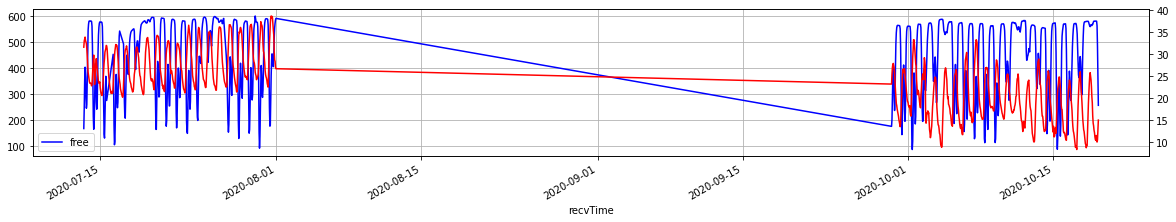

In [43]:
ax= zone1_df.plot(figsize=(20,3),grid=True, color='blue');
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
meteor['tmed'].plot(ax=ax2, color='red');

In [44]:
meteor['tmed'].drop(meteor.index[0])


2020-07-13 11:00:00    33.0
2020-07-13 12:00:00    33.4
2020-07-13 13:00:00    33.9
2020-07-13 14:00:00    33.1
2020-07-13 15:00:00    32.8
                       ... 
2020-10-19 04:00:00    11.1
2020-10-19 05:00:00    10.0
2020-10-19 06:00:00    10.5
2020-10-19 07:00:00    12.6
2020-10-19 08:00:00    15.0
Name: tmed, Length: 925, dtype: float64

In [50]:
zone1_df['free'].shape
meteor['tmed'].shape

(926,)

In [51]:
#r, p = pearsonr(zone1_df['free'], meteor['tmed'].drop(meteor.index[0]))
r, p = pearsonr(zone1_df['free'], meteor['tmed'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.45676293394461576 and p-value: 6.4313011058142346e-49


radmed vs free parking

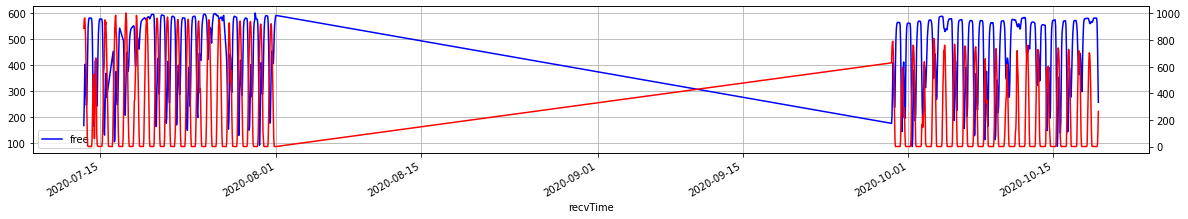

In [52]:
ax= zone1_df.plot(figsize=(20,3),grid=True, color='blue');
ax2 = ax.twinx()
ax2.spines['right'].set_position(('axes', 1.0))
meteor['radmed'].plot(ax=ax2, color='red');

In [54]:
#r, p = pearsonr(zone1_df['free'], meteor['radmed'].drop(meteor.index[0]))
r, p = pearsonr(zone1_df['free'], meteor['radmed'])
print(f"Scipy computed Pearson r: {r} and p-value: {p}")

Scipy computed Pearson r: -0.5562859606516746 and p-value: 2.3967096021455466e-76


## Format data

In [55]:
n_steps = 12
T_ = 1

In [56]:
#input: flow(t), flow(t-1), ..,flow(t-prev_hours). output: parking(t+T)
def generate_univariate_time_series_fn(zone_parking, subflow, prev_hours, T=1):
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_value = zone_parking.iloc[prev_hours + i +T -1]
        s = np.append(mob_values,parking_value).reshape(-1,prev_hours+1)
        series.append(s)
    series= np.array(series)
    series = series.reshape(series.shape[0],prev_hours+1,1)
    return series

#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,
#parking(t-prev_hours),. output: parking(t+T)
def generate_univariate_time_series_fn2(zone_parking, subflow, prev_hours, T=1): 
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking[i:(prev_hours + i +T)]
        s = np.append(mob_values,parking_values).reshape(-1,prev_hours*2+1)
        series.append(s)
    series= np.array(series)
    series = series.reshape(series.shape[0],prev_hours*2+1,1)
    return series

#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,
#parking(t-prev_hours), meteor(t), meteor(t-1), ..., meteor(t-prev_hours) output: parking(t+T)
def generate_univariate_time_series_fn3(zone_parking, subflow, meteoro, prev_hours, T=1): 
    series = []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking[i:i+prev_hours +T].values
        meteor_values = meteoro[i:i+prev_hours].values.reshape(-1,1) 
        s = np.concatenate((mob_values,meteor_values,parking_values), axis=0)#.reshape(-1, prev_hours*3+T)
        series.append(s)
    series2 = np.asarray(series, dtype=np.float32)
   
    return series2

In [58]:
def generate_time_series_for_rnn_fn(zone_parking, subflow, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        X.append(mob_values)
        parking_values = zone_parking.iloc[i+T:i+T+prev_hours].values
        Y.append(parking_values)
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,1)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],prev_hours,1)
    
    return X,Y

#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,#parking(t-prev_hours),. 
#output: parking(t+1), parking (t+2),..,parking(t+T)
def generate_time_series_for_rnn_fn2(zone_parking, subflow, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking[i:i+prev_hours].values
        two_dim_values = np.concatenate((mob_values, parking_values), axis=0)#.reshape(-1,2)
        X.append(two_dim_values)
        parking_values = zone_parking.iloc[i+T:i+T+prev_hours].values
        Y.append(parking_values)
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,2)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],prev_hours,1)
    
    return X,Y

#input: flow(t), flow(t-1), ..,flow(t-prev_hours), parking(t), parking(t-1),...,parking(t-prev_hours),..,meteo(t),..,meteo(t-prev_hours)
#output: parking(t+1), parking (t+2),..,parking(t+T)
def generate_time_series_for_rnn_fn3(zone_parking, subflow, meteoro, prev_hours, T=1):
    X= []
    Y= []
    for i in range(0,subflow.shape[0]-prev_hours-T):
        mob_values = subflow[i:i+prev_hours].values
        parking_values = zone_parking[i:i+prev_hours].values
        meteoro_values = meteoro[i:i+prev_hours].values
        
        three_dim_values = np.concatenate((mob_values, parking_values,meteoro_values), axis=1)#.reshape(-1,2)
        X.append(three_dim_values)
        parking_values = zone_parking.iloc[i+T:i+T+prev_hours].values
        Y.append(parking_values)
    X= np.array(X)
    X = X.reshape(X.shape[0],prev_hours,6)
    
    Y= np.array(Y)
    Y = Y.reshape(Y.shape[0],prev_hours,1)
    
    return X,Y

### Scale data

In [59]:
scaler_flow =  StandardScaler()
flow_scaled = scaler_flow.fit_transform(mob_flows[9].loc[target_days].values)
flow_scaled_df = pd.DataFrame(flow_scaled)
flow_scaled_df.head()

,0
0,1.041165
1,0.554424
2,0.402630
3,0.517618
4,1.501898


In [60]:
scaler_parking =  StandardScaler()
zone_scaled =scaler_parking.fit_transform(zone1_df.values)
parking_scaled_df = pd.DataFrame(zone_scaled)
parking_scaled_df.head()

,0
0,-2.039013
1,-1.472440
2,-0.715219
3,-0.336895
4,-0.636502


In [61]:
scaler_meteor =  StandardScaler()
meteor_scaled =scaler_meteor.fit_transform(meteor.loc[target_days].values)
meteor_scaled_df = pd.DataFrame(meteor_scaled)
meteor_scaled_df.head()

,0,1,2,3
0,1.196171,1.980198,0.880040,-0.047954
1,1.402460,2.187975,1.348472,-0.047954
2,1.461400,2.223176,1.660761,-0.047954
3,1.535074,2.091719,1.973049,-0.047954
4,1.417195,1.782389,2.441482,-0.047954


In [62]:
X,y=generate_time_series_for_rnn_fn3(parking_scaled_df, flow_scaled_df, meteor_scaled_df, 12, 1)

In [63]:
X.shape, y.shape

((913, 12, 6), (913, 12, 1))

### Generate time series samples

In [64]:
ts = generate_univariate_time_series_fn(parking_scaled_df, flow_scaled_df, n_steps, T_)
ts[0]

array([[ 1.0411652 ],
       [ 0.55442355],
       [ 0.40262978],
       [ 0.51761774],
       [ 1.50189836],
       [ 0.78828006],
       [ 1.04067332],
       [ 0.83946344],
       [ 1.09338674],
       [ 1.01436231],
       [ 0.40698919],
       [-0.20315889],
       [ 0.93576822]])

In [65]:
ts.shape

(913, 13, 1)

In [66]:
ts2= generate_univariate_time_series_fn2(parking_scaled_df, flow_scaled_df, n_steps, T_)
ts2[0]

array([[ 1.0411652 ],
       [ 0.55442355],
       [ 0.40262978],
       [ 0.51761774],
       [ 1.50189836],
       [ 0.78828006],
       [ 1.04067332],
       [ 0.83946344],
       [ 1.09338674],
       [ 1.01436231],
       [ 0.40698919],
       [-0.20315889],
       [-2.03901311],
       [-1.47244006],
       [-0.71521884],
       [-0.33689526],
       [-0.63650167],
       [-1.19791216],
       [-1.47437435],
       [-1.37426553],
       [-0.66558696],
       [ 0.07475274],
       [ 0.69005492],
       [ 0.85658671],
       [ 0.93576822]])

In [67]:
ts2.shape

(913, 25, 1)

In [68]:
ts3 = generate_univariate_time_series_fn3(parking_scaled_df, flow_scaled_df, meteor_scaled_df, n_steps, T_)


In [69]:
ts3.shape

(913, 73, 1)

In [70]:
n_series = ts.shape[0]

## Split training-test

In [71]:
training_rate = 0.7

In [72]:
n_series_training = round(n_series * training_rate)


In [73]:
X_train, y_train = ts[:n_series_training,:n_steps], ts[:n_series_training, -1]
X_valid, y_valid = ts[n_series_training:,:n_steps], ts[n_series_training:, -1]

In [74]:
X_train.shape, y_train.shape

((639, 12, 1), (639, 1))

In [75]:
X_valid.shape, y_valid.shape

((274, 12, 1), (274, 1))

In [76]:
def generate_train_test(zone_parking, subflow, meteoro =[], prev_hours = 12, T=1, fun =1, tr= 0.9, nfeatures=1):

    if(fun==1):
        ts = generate_univariate_time_series_fn(zone_parking, subflow, n_steps, T_)
    elif(fun==2): 
        ts = generate_univariate_time_series_fn2(zone_parking, subflow, n_steps, T_)
    else:
        ts = generate_univariate_time_series_fn3(zone_parking, subflow, meteoro, n_steps, T_)
    n_series = ts.shape[0]
    training_rate = tr
    n_series_training = round(n_series * training_rate)
    X_train, y_train = ts[:n_series_training,:n_steps*nfeatures], ts[:n_series_training, -1]
    X_valid, y_valid = ts[n_series_training:,:n_steps*nfeatures], ts[n_series_training:, -1]
    return X_train, y_train, X_valid, y_valid

In [77]:
def generate_train_test_for_rnn(zone_parking, subflow, meteoro =[], prev_hours= 12, T=1, fun =1, tr= 0.9):
    if(fun==1):
        X,Y = generate_time_series_for_rnn_fn(zone_parking, subflow, n_steps, T_)
    elif fun== 2: 
        X,Y = generate_time_series_for_rnn_fn2(zone_parking, subflow, n_steps, T_)
    else:
        X,Y = generate_time_series_for_rnn_fn3(zone_parking, subflow, meteoro, n_steps, T_)

    n_train_samples = round(X.shape[0] * tr)
    X_train = X[:n_train_samples]
    y_train = Y[:n_train_samples]

    X_valid = X[n_train_samples:]
    y_valid = Y[n_train_samples:]
      
    return X_train, y_train, X_valid, y_valid

## Test DNN models

In [78]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    #plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    #plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

In [79]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [80]:
def compute_metrics_fn(y_valid, y_hat, scaler):
    ## actual train and test values
    y_hat_resc = scaler_parking.inverse_transform(y_hat)
    y_valid_resc = scaler_parking.inverse_transform(y_valid)

    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [81]:
def plot_prediction_vs_groundtruth_fn(y_valid, y_hat):
    y_hat_resc = scaler_parking.inverse_transform( y_hat[:,-1].reshape(-1,))
    y_valid_resc = scaler_parking.inverse_transform(y_valid[:,-1].reshape(-1,))
    plt.plot(np.arange(len(y_hat_resc)), y_hat_resc, "b.-", label="y_hat")
    plt.plot(np.arange(len(y_valid_resc)), y_valid_resc, "r.-", label="y_true")
    plt.legend(fontsize=14)
    plt.xlabel("Timestamp")
    plt.ylabel("Free places")
    plt.grid(True)

### MLP - benchmark

In [82]:
import tensorflow as tf
from tensorflow import keras

In [83]:
np.random.seed(42)
tf.random.set_seed(42)

model_mlp = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[n_steps, 1]),
    keras.layers.Dense(1)
])

model_mlp.compile(loss="mse", optimizer="adam")
history = model_mlp.fit(X_train, y_train, epochs=100, validation_data=(X_valid, y_valid))

Epoch 1/100
20/20 [==============================] - 0s 20ms/step - loss: 1.2691 - val_loss: 1.2621
Epoch 2/100
20/20 [==============================] - 0s 8ms/step - loss: 1.1306 - val_loss: 1.1391
Epoch 3/100
20/20 [==============================] - 0s 10ms/step - loss: 1.0202 - val_loss: 1.0527
Epoch 4/100
20/20 [==============================] - 0s 13ms/step - loss: 0.9425 - val_loss: 0.9895
Epoch 5/100
20/20 [==============================] - 0s 10ms/step - loss: 0.8836 - val_loss: 0.9475
Epoch 6/100
20/20 [==============================] - 0s 10ms/step - loss: 0.8431 - val_loss: 0.9158
Epoch 7/100
20/20 [==============================] - 0s 10ms/step - loss: 0.8108 - val_loss: 0.8944
Epoch 8/100
20/20 [==============================] - 0s 9ms/step - loss: 0.7871 - val_loss: 0.8775
Epoch 9/100
20/20 [==============================] - 0s 11ms/step - loss: 0.7692 - val_loss: 0.8639
Epoch 10/100
20/20 [==============================] - 0s 7ms/step - loss: 0.7522 - val_loss: 0.8489
Ep

20/20 [==============================] - 0s 5ms/step - loss: 0.5027 - val_loss: 0.5471
Epoch 83/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5024 - val_loss: 0.5466
Epoch 84/100
20/20 [==============================] - 0s 5ms/step - loss: 0.5017 - val_loss: 0.5464
Epoch 85/100
20/20 [==============================] - 0s 6ms/step - loss: 0.5020 - val_loss: 0.5431
Epoch 86/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5009 - val_loss: 0.5457
Epoch 87/100
20/20 [==============================] - 0s 4ms/step - loss: 0.5005 - val_loss: 0.5443
Epoch 88/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5003 - val_loss: 0.5444
Epoch 89/100
20/20 [==============================] - 0s 3ms/step - loss: 0.5002 - val_loss: 0.5456
Epoch 90/100
20/20 [==============================] - 0s 3ms/step - loss: 0.4997 - val_loss: 0.5445
Epoch 91/100
20/20 [==============================] - 0s 4ms/step - loss: 0.4997 - val_loss: 0.5409
Epoch 92/100


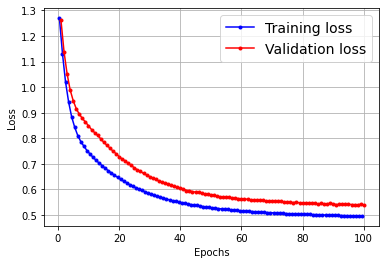

In [84]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

In [85]:
y_hat = model_mlp.predict(X_valid)

#### Get metrics

In [86]:
mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid, y_hat, scaler_parking)

print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))

MAE: 76.587, MSE: 10430.484, RMSE: 102.130, CVRMSE: 22.031, MAPE: 21.860


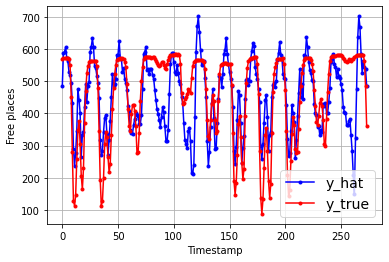

In [87]:
plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

In [88]:
def mlp_benchmark(X_train, y_train, X_valid, y_valid, nfeatures=1):
    np.random.seed(42)
    tf.random.set_seed(42)

    print(X_train.shape, y_train.shape, X_valid.shape, y_valid.shape)
    model_mlp = keras.models.Sequential([
        keras.layers.Flatten(input_shape=[n_steps*nfeatures, 1]),
        keras.layers.Dense(50),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(50),
        keras.layers.Dropout(rate=0.2),
        keras.layers.Dense(50),

        keras.layers.Dense(1)
    ])

    model_mlp.compile(loss="mse", optimizer="adam")
    history = model_mlp.fit(X_train, y_train, epochs=200, verbose=0, validation_data=(X_valid, y_valid))
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()
    y_hat = model_mlp.predict(X_valid)#.reshape(-1,)
    #print(y_hat.shape, y_valid.shape)
    mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid, y_hat, scaler_parking)
    print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))
    plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

(822, 12, 1) (822, 1) (91, 12, 1) (91, 1)


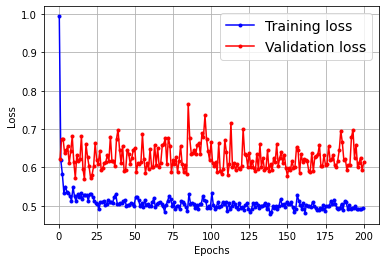

MAE: 79.344, MSE: 11855.574, RMSE: 108.883, CVRMSE: 22.811, MAPE: 20.462


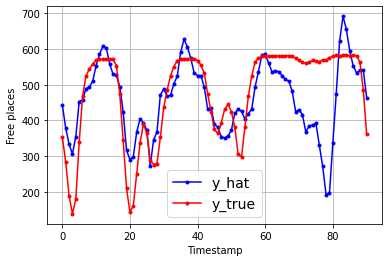

In [89]:
# Model with flows as inputs
X_train, y_train, X_valid, y_valid = generate_train_test(parking_scaled_df, 
                                                         flow_scaled_df, 
                                                         prev_hours=n_steps, 
                                                         fun= 1,
                                                         T=1)
mlp_benchmark(X_train, y_train, X_valid, y_valid)

(822, 24, 1) (822, 1) (91, 24, 1) (91, 1)


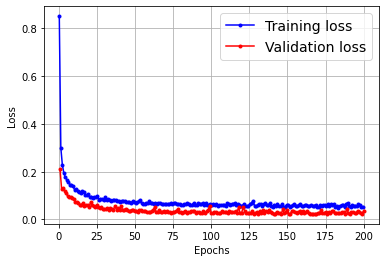

MAE: 22.221, MSE: 691.999, RMSE: 26.306, CVRMSE: 5.511, MAPE: 5.792


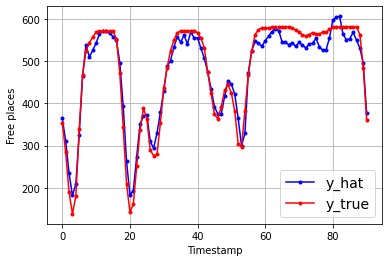

In [90]:
# Model with flows and parking as inputs
X_train, y_train, X_valid, y_valid = generate_train_test(parking_scaled_df, flow_scaled_df, 
                                                         prev_hours=n_steps, T=1, fun = 2, nfeatures=2)
mlp_benchmark(X_train, y_train, X_valid, y_valid, nfeatures=2)

(822, 72, 1) (822, 1) (91, 72, 1) (91, 1)


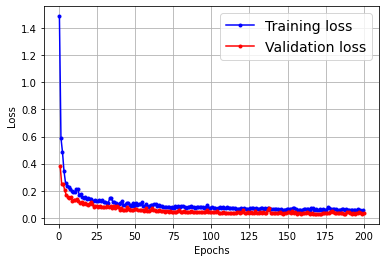

MAE: 20.185, MSE: 630.766, RMSE: 25.115, CVRMSE: 5.262, MAPE: 4.885


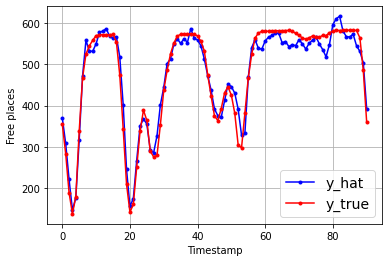

In [91]:
# Model with flows, parkings and meteorological data as inputs
X_train, y_train, X_valid, y_valid = generate_train_test(parking_scaled_df, 
                                                         flow_scaled_df, 
                                                         meteor_scaled_df,
                                                         prev_hours=n_steps, T=1, fun = 3, nfeatures=6)

mlp_benchmark(X_train, y_train, X_valid, y_valid, nfeatures=6) 

###  GRU model

In [92]:
def gru_model(X_train, y_train, X_valid, y_valid, fun=1):
    np.random.seed(42)
    tf.random.set_seed(42)

    model_gru = keras.models.Sequential([
        keras.layers.GRU(50, return_sequences=True,  input_shape=[None, fun]),
        keras.layers.GRU(20, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(20)),
        keras.layers.Dense(1)
    ])

    model_gru.compile(loss="mse", optimizer="adam")
    history = model_gru.fit(X_train, y_train, verbose=0, epochs=100, validation_data=(X_valid, y_valid))
    
    plot_learning_curves(history.history["loss"], history.history["val_loss"])
    plt.show()
    
    y_hat = model_gru.predict(X_valid)

    mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid[:,-1].reshape(-1,), y_hat[:,-1].reshape(-1,), scaler_parking)

    print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))
    
    plot_prediction_vs_groundtruth_fn(y_valid, y_hat)

Only with flow as input

In [93]:
X_train, y_train, X_valid, y_valid= generate_train_test_for_rnn(parking_scaled_df, 
                                                                flow_scaled_df, 
                                                                prev_hours=n_steps, 
                                                                T=1, 
                                                                fun=1)

In [94]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((822, 12, 1), (822, 12, 1), (91, 12, 1), (91, 12, 1))

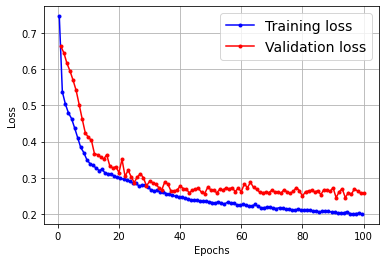

MAE: 41.129, MSE: 3151.819, RMSE: 56.141, CVRMSE: 11.762, MAPE: 10.337


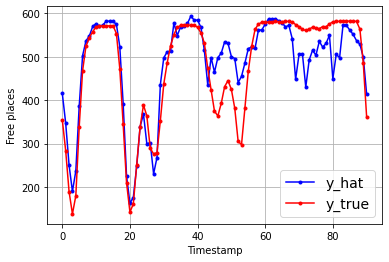

In [95]:
gru_model(X_train, y_train, X_valid, y_valid)

Now we try with flow + parking as input

In [96]:
X_train, y_train, X_valid, y_valid= generate_train_test_for_rnn(parking_scaled_df, 
                                                                flow_scaled_df, 
                                                                prev_hours=n_steps, 
                                                                T=1, 
                                                                fun=2)

In [97]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((822, 12, 2), (822, 12, 1), (91, 12, 2), (91, 12, 1))

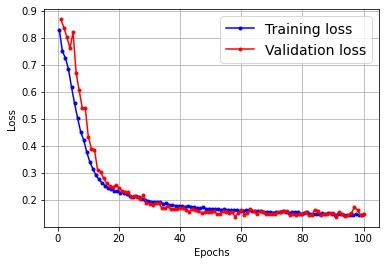

MAE: 24.868, MSE: 1124.479, RMSE: 33.533, CVRMSE: 7.025, MAPE: 6.412


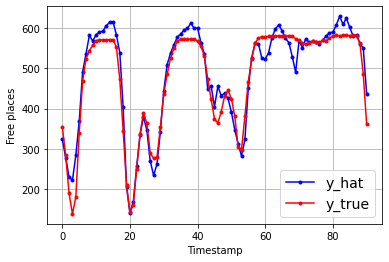

In [98]:
gru_model(X_train, y_train, X_valid, y_valid, 2)

Now with flow+parking+weather

In [99]:
X_train, y_train, X_valid, y_valid= generate_train_test_for_rnn(parking_scaled_df, 
                                                                flow_scaled_df, 
                                                                meteor_scaled_df, 
                                                                prev_hours=n_steps, 
                                                                T=1, 
                                                                fun=3)

In [100]:
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((822, 12, 6), (822, 12, 1), (91, 12, 6), (91, 12, 1))

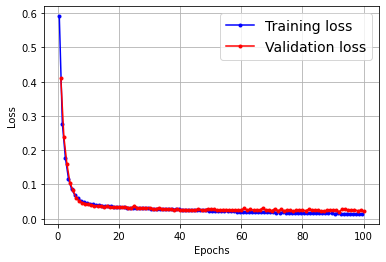

MAE: 12.081, MSE: 251.978, RMSE: 15.874, CVRMSE: 3.326, MAPE: 3.145


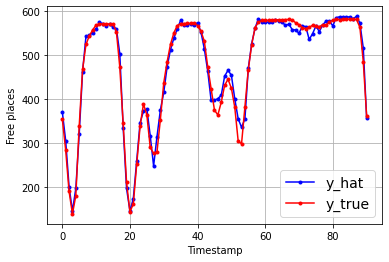

In [101]:
gru_model(X_train, y_train, X_valid, y_valid, 6)

------------------------------------

### Naive approach

We just predict with the last value of the parking

In [102]:
y_hat= X_valid[:,11,-5]

MAE: 30.266, MSE: 2350.696, RMSE: 48.484, CVRMSE: 10.158, MAPE: 9.127


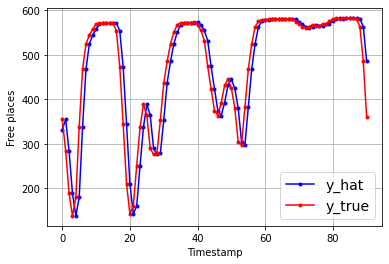

In [103]:
mae_, mse_, rmse_, cvrmse_, mape_ = compute_metrics_fn(y_valid[:,-1].reshape(-1,), 
                                                       y_hat, 
                                                       scaler_parking)

print('MAE: {:.3f}, MSE: {:.3f}, RMSE: {:.3f}, CVRMSE: {:.3f}, MAPE: {:.3f}'.format(mae_, mse_, rmse_, cvrmse_, mape_))

y_hat_resc = scaler_parking.inverse_transform( y_hat)
y_valid_resc = scaler_parking.inverse_transform(y_valid[:,-1].reshape(-1,))
plt.plot(np.arange(len(y_hat_resc)), y_hat_resc, "b.-", label="y_hat")
plt.plot(np.arange(len(y_valid_resc)), y_valid_resc, "r.-", label="y_true")
plt.legend(fontsize=14)
plt.xlabel("Timestamp")
plt.ylabel("Free places")
plt.grid(True)

In [ ]:
print("That's all folks!")